# To run this, you need to run (or have run) the following in docker:
```
pip install textblob
pip install nltk
pip install twitterscraper
pip install pandas_datareader
pip install yahoo-finance
```

In [159]:
from twitterscraper import query_tweets
from twitterscraper.query import query_tweets_once as query_tweets_advanced
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import hypertools as hyp
import numpy as np
from textblob import TextBlob as tb
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime as dt
from yahoo_finance import Share
import nltk
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Define some useful Twitter-related functions

- Find most recent tweets containing a given keyword
- Fit topic models to a set of tweets
- Do sentiment analyses on tweets
- Get the tweet text and dates

In [179]:
# function for scraping twitter for one or more keywords and returning a dictionary with:
# - tweets: the tweet text (list of length n_tweets)
# - datetimes: the tweet date/time (as a DateTime object)
# - topicvecs: the tweet topic vectors (numpy array with n_tweets rows and n_topics columns)
# - topwords: the top n words from each topic (list of length n_topics, where each element is a list of n_words)
# - sentiments: the sentiment valence of each tweet (numpy array of length n_tweets)

def twitter_witch(keywords, n_tweets=500, n_topics=10, n_words=5, model=None, use_advanced=False):
    #if keywords is a list, combine all keywords into a single string, where each word is separated by " OR "
    if type(keywords) == list:
        if use_advanced:
            print('Cannot scrape lists of advanced queries')
            return None
        else:
            keywords = ' OR '.join(keywords)
    
    #get the tweets
    tweets = []
    if not use_advanced:
        for tweet in query_tweets(keywords, n_tweets)[:n_tweets]:
            tweets.append(tweet)
    else:
        tweets = query_tweets_advanced(keywords, num_tweets=n_tweets, limit=n_tweets)
    
    #get the tweet text
    tweet_text = list(map(lambda x: x.text, tweets))
    
    #fit a topic model to the tweet text    
    n_features = 1000
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(tweet_text)    
    vocab = tf_vectorizer.get_feature_names()
    
    if model == None:
        lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
    else:
        lda = model            
    tweet_topics = lda.fit(tf)
    
    def get_top_words(model, vocab, n_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):       
            next = topic.argsort()[:-n_words - 1:-1]
            top_words.append(list(map(lambda x: vocab[x], next)))
        return top_words
    
    def tweet_sentiment(tweet):
        b = tb(tweet)
        return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))
    
    #get the tweet datetimes
    tweet_dts = list(map(lambda x: x.timestamp, tweets))
    
    return {'tweets': tweet_text,
            'datetimes': tweet_dts,
            'topicvecs': lda.components_.T,
            'topwords': get_top_words(lda, vocab, n_words),
            'sentiments': np.array(list(map(tweet_sentiment, tweet_text))),
            'model': lda}

# Define some useful finance-related functions

Given a stock ticker symbol and a date, return a dictionary with the following keys/values (strings or floats, or None if unavailable):
- name: The company name
- open: The opening price from that day
- close: The closing price from that day
- vol: The trading volume from that day
- price_change: The change in price from the previous day, in whatever the trading currency is
- percent_change: The change in price from the previous day, as a percentage
- currency: The currency (e.g. USD)

In [234]:
def finance_wizard(name, date):
    def floater(n):
        '''
        Turn n into a float.  Acceptable values are: floats or dataframes
        '''
        if type(n) == pd.core.series.Series:
            return n.values[-1]
        else:
            return n
    
    def datefloor(date):
        '''
        Reset a date to 00:00:00 and return the new datetime object
        '''
        return dt.datetime(year=date.year, month=date.month, day=date.day)
    
    x = Share(name.upper())
    info = {'name': '',
            'symbol': name,
            'open': np.nan,
            'close': np.nan,
            'vol': np.nan,
            'price_change': np.nan,
            'percent_change': np.nan,
            'currency': ''}
            
    info['name'] = x.get_name()
    info['currency'] = x.get_currency()
    
    if info['name'] == None: #ticker symbol not found
        return info
    
    end = datefloor(date)
    start = end - dt.timedelta(5) #look up to 5 days prior to the target date to account for days when the markets were closed
    
    try:
        data = pdr.data.DataReader(name.upper(), 'yahoo', start, end)
    except:
        return info
    
    info['open'] = floater(data.loc[data.index[-1]]['Open'])
    info['close'] = floater(data.loc[data.index[-1]]['Adj Close'])
    info['vol'] = floater(data.loc[data.index[-1]]['Volume'])
    info['price_change'] = info['open'] - floater(data.loc[data.index[-2]]['Open'])
    info['percent_change'] = np.divide(info['price_change'], info['open'])
    
    return info

## Tweet topics and sentiments as market predictors

Define a stock symbol and company name.  Define a start and end date.  For each day, get up to n tweets containing the company name (with twitter_witch stats), along with financial info for that day (with finance_wizard stats).

In [277]:
def get_tweets_and_stocks(symbol='AAPL', keyword='apple', start=None, end=None, n_tweets=100):
    if end == None:
        end = dt.datetime.today()
    if start == None:
        start = end - dt.timedelta(30)
    
    def date2str(date):
        return date.strftime('%Y-%m-%d')
    
    if start >= end:
        return None
    
    d = start
    twitter_data = []
    finance_data = []
    
    print('Getting information for ' + str((end - start).days) + ' days')
    while d <= end:
        search_string = '"' + keyword + '"%20since%3A' + date2str(d) + '%20until%3A' + date2str(d + dt.timedelta(1))
        if len(twitter_data) == 0:
            twitter_data.append(twitter_witch(search_string, n_tweets=n_tweets, use_advanced=True))
        else:
            twitter_data.append(twitter_witch(search_string, n_tweets=n_tweets, use_advanced=True, model=twitter_data[0]['model']))
        finance_data.append(finance_wizard(symbol, d))
        print('.', end='')                
        d = d + dt.timedelta(1)
    print('done')
    
    return {'tweets': twitter_data, 'stocks': finance_data}

In [278]:
info = get_tweets_and_stocks(n_tweets=10)

Getting information for 30 days
...............................done


In [279]:
#compile useful info (by day)
average_sentiments = list(map(lambda x: np.mean(x['sentiments']), info['tweets']))
average_topics = np.vstack(list(map(lambda x: np.mean(x['topicvecs'], axis=0), info['tweets'])))
closing_prices = list(map(lambda x: x['close'], info['stocks']))

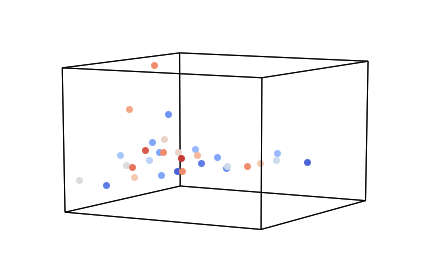

In [285]:
hyp.plot(average_topics, 'o', group=average_sentiments, palette='coolwarm');

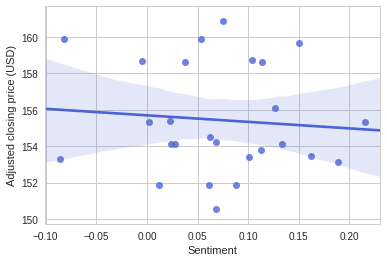

In [286]:
h = sns.regplot(x=np.array(average_sentiments), y=np.array(closing_prices));
h.set(xlabel='Sentiment', ylabel='Adjusted closing price (' + info['stocks'][0]['currency'] + ')');